# Exploring Building Permit Data
EDA for Toronto Bulding Permits using the CKAN API

## Create CKAN API request methods
Pass queries using SQL and return responses as appropriate objects: either a dataframe, float/str/int, or error out with a response code as required

In [ ]:
from helpers.ckan import Ckan

## Export to CSV
Use Ckan class to export data from a Ckan package to a CSV file. Run for all relevant packages for this project.

In [ ]:
import os
import re
import time

def make_csv_source_path(package_id: str, dirpath: str) -> str:
    return os.path.join(dirpath, re.sub("\\W+", "-", package_id.lower()) + ".csv")

def export_csv_from_ckan(package_id: str, dirpath = "../data/source/csv/") -> None:
    ckan = Ckan()
    ckan.set_package_id(package_id)
    ckan.get_pkg_info()
    ckan.find_resource_endpoints()
    ckan.export_csv(make_csv_source_path(package_id=package_id, dirpath=dirpath))

In [ ]:
pkg_ids = [
    "building-permits-active-permits",
    "building-permits-cleared-permits",
    "address-points-municipal-toronto-one-address-repository",
    "neighbourhoods",
]

for pkg_id in pkg_ids:
    export_csv_from_ckan(package_id=pkg_id)
    time.sleep(6)

## Pandas exploration
Check the data for its features (primary keys, data types, attributes)

In [1]:
import pandas as pd
df = pd.read_csv("../data/source/csv/building-permits-active-permits.csv", dtype=str)

In [ ]:
df.drop_duplicates().shape

In [ ]:
df.columns.to_list()

Find the minimum columns required to create a primary key (preserve all rows from source).

In [ ]:
df[['PERMIT_NUM', 'REVISION_NUM', 'PERMIT_TYPE', 'BUILDER_NAME']].drop_duplicates().shape

The columns we can use to create a hash for a primary key are:
- `PERMIT_NUM`
- `REVISION_NUM`
- `PERMIT_TYPE`
- `BUILDER_NAME`

There are some really efficient hashing algos in python created by [Maruice Borgmeier](https://mauricebrg.com/2022/12/even-more-efficient-hashing-of-columns-in-a-pandas-dataframe.html). We can implement the V3 version that relies on pandas solely for typing the dataframe into strings for hashing.

Hashing algos:
- **xxHash** <-- fastest, use this
- crc32 (fast, old, too many collisions)
- md5 (fast, use as an alternative)
- sha-1 (only slightly less fast)

In [2]:
# Code adapted from Maurice Borgmeier's efficient pandas hashing blog post:
# https://mauricebrg.com/2022/12/even-more-efficient-hashing-of-columns-in-a-pandas-dataframe.html


import abc
import typing
import xxhash
import pandas as pd

class AbstractHasher(abc.ABC):
    """Implement an abstract base class for the Abstract Hasher
    This class prepares code for a concrete Hasher class to carry out dataframe hashing.
    dataframe:

    Attributes
    ----------
    dataframe : pd.Dataframe
        the pandas dataframe with columns to be hashed
    target_columns_name : str
        the name of the column containing the hashes
    columns_to_hash : list[str]
        the list of columns to be used to create the hash

    Methods
    -------
    hash :
        An abstract hash that runs the hash methods from concrete implements
    """

    dataframe: pd.DataFrame
    target_column_name: str
    columns_to_hash: typing.List[str]
    num_records: int

    def __init__(
            self, 
            dataframe: pd.DataFrame,
            columns_to_hash: typing.List[str], 
            target_column_name: str) -> 'AbstractHasher':
        """
        Initialize the AbstractHasher class:

        Attributes
        ----------
        dataframe : pd.Dataframe
            the pandas dataframe with columns to be hashed
        target_columns_name : str
            the name of the column containing the hashes
        columns_to_hash : list[str]
            the list of columns to be used to create the hash
        """

        self.dataframe = dataframe.copy()
        self.target_column_name = target_column_name
        self.columns_to_hash = columns_to_hash
        self.num_records = len(dataframe)

    @abc.abstractmethod
    def hash(self) -> pd.DataFrame:
        """Hash the columns"""

In [3]:
HASH_FIELD_SEPARATOR = "|"
HASH_FUNCTION = xxhash.xxh32


class PyHasher(AbstractHasher):
    """
    Hasher uses itertuples instead of converting values to a list
    """

    def hash(self) -> pd.DataFrame:
        def hash_string_iterable(string_iterable: typing.Iterable[str]) -> str:
            input_str = HASH_FIELD_SEPARATOR.join(string_iterable)
            return HASH_FUNCTION(input_str.encode("utf-8")).hexdigest()

        """
        Apply the hash_string_iterable method to the specified columns of an input 
        dataframe that was typed into a str, then converted into an iter object where 
        each row is a tuple. This creates a series with the same number of items as 
        the input dataframe, and can be inserted into the specified hash column name.
        """
        
        hashed_series = pd.Series(
            map(
                hash_string_iterable,
                self.dataframe[self.columns_to_hash]
                .astype(str)
                .itertuples(index=False, name=None),
            ),
            index=self.dataframe.index,
        )

        self.dataframe[self.target_column_name] = hashed_series

        return self.dataframe

In [4]:
PK_COLS = ['PERMIT_NUM', 'REVISION_NUM', 'PERMIT_TYPE', 'BUILDER_NAME']

df = PyHasher(dataframe=df, columns_to_hash=PK_COLS, target_column_name="permit_id").hash()

## Explore address data
Explore joining address data to obtain neighbourhood data and geolocation points. There are two possible ways to show 'hotspots' of renovations: 
1. By neighbourhood, or geofenced by neighbourhood, and
2. By permit value. 

(1) and (2) can be combined to provide a sense of moneyh being spent in high-activity neighbourhoods.

In [5]:
df_loc = pd.read_csv("../data/source/csv/address-points-municipal-toronto-one-address-repository.csv", dtype=str)

In [ ]:
df_loc.columns

In [ ]:
df_loc["WARD_NAME"].nunique()

**NOTE**: There is no current link between address points and neighbourhoods. Therefore, we need to geofence the Address Point data to annotate it with the 158 neighbourhoods to which each address belongs. This can be done once a month in case there are new addresses or plots that come up.

In [ ]:
df[['STREET_NUM', 'STREET_NAME', 'STREET_TYPE', 'GEO_ID']].head()

In [ ]:
df['GEO_ID'].head().to_list()

In [ ]:
df_loc[df_loc['ADDRESS_POINT_ID'].isin(df['GEO_ID'].head().to_list())]

We found that **`GEO_ID` from the *building permits* table = `ADDRESS_POINT_ID` from the *address points* table**. This simplifies enriching the building permits database with neighbourhood and goelocation points further in the analysis pipeline. Next steps are to continue EDA with the building permits data to create a draft of the main transformations required to get from the data to an analytics dashboard, then modularize transformations to simplify the raw data.

## EDA: Join all building permit data
We want to combine **active** and **cleared** permit data to create a full dataset of permits with their dates such that we can window all permits within a given date filter. These joins and appends might be changed into a minimal version of transformations that are run on filtered queries made to the CKAN api.

In [5]:
df_cleared = pd.read_csv("../data/source/csv/building-permits-cleared-permits.csv", dtype=str)

In [ ]:
df.columns

In [ ]:
all([c in df.columns for c in df_cleared.columns])

In [6]:
df = pd.concat([
        df.drop("_id", axis=1),
        PyHasher(df_cleared.drop("_id", axis=1), PK_COLS, "permit_id").hash()
    ])

In [ ]:
df.columns

In [ ]:
show_cols = [
    'PERMIT_NUM', 'REVISION_NUM', 'PERMIT_TYPE', 'WARD_GRID', 'APPLICATION_DATE', 'ISSUED_DATE',
       'COMPLETED_DATE', 'STATUS', 'DESCRIPTION', 'CURRENT_USE',
       'PROPOSED_USE', 
       'EST_CONST_COST', 'BUILDER_NAME', 'permit_id'
]
df[show_cols].sort_values("APPLICATION_DATE")

In [ ]:
[
    sum(df["APPLICATION_DATE"].isna()),
    sum(df["ISSUED_DATE"].isna()),
    sum(df["COMPLETED_DATE"].isna()),
]

In [ ]:
df[["APPLICATION_DATE", "ISSUED_DATE", "COMPLETED_DATE"]].isnull().all(axis=1).sum()

**NOTE**: There are permit records with at least one date, therefore we need to create an "EFFECTIVE_DATE" column that pulls the latest date available between Application, Issued, and Completed dates. Since Completed > Issued > Application dates, the effective date will be the date that appears first in that order.

Alternatively: we choose the maximum date present in the record. We will use this strategy as it is quicker to implement.

In [7]:
date_columns = ["APPLICATION_DATE", "ISSUED_DATE", "COMPLETED_DATE"]
df["effective_date"] = df[date_columns].fillna("").max(axis=1, skipna=True)


## EDA: Windowing data
Experiment with windowing data to capture the wards with the highest permit activity. We want to see which wards have the highest activity in permit value and the most permits within the last month, quarter, and year. We also want to see the trend for each ward (permit value and number of permits) over time. Eventually we will create a static crosswalk between neighbourhoods and address points to map each address to a neighbourhood.

We will opt to use the `dt.to_period` conversion for the date series. This function depends on a frequency argument which is a representation of the [date windowing defined by pandas](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#timeseries-period-aliases). We'll use `M` for **monthly**, `Q` for **quarterly**, and `Y` for **yearly**.

In [ ]:
def count_unique(df: pd.DataFrame) -> list:
    return [{col: df_loc[col].nunique()} for col in df_loc.columns]

In [ ]:
ALLOWED_PERMIT_TYPES = [
    'Residential Building Permit',
    'Mechanical(MS)', 'Plumbing(PS)', 'Multiple Use Permit',
    'Change of Use Permit', 'Building Additions/Alterations',
    'Small Residential Projects', 'Conditional Permit',
    'Fire/Security Upgrade', 'Designated Structures',
    'Drain and Site Service', 'Partial Permit',
    'Demolition Folder (DM)', 'New Houses', 'New Building',
]
filtered = df.loc[
    (df["STATUS"] != "Cancelled") &
    (df["PERMIT_TYPE"].isin(ALLOWED_PERMIT_TYPES))
]
filtered = filtered[["GEO_ID", "effective_date", "EST_CONST_COST"]]
filtered = filtered.merge(df_loc[["ADDRESS_POINT_ID", "WARD_NAME"]], left_on="GEO_ID", right_on="ADDRESS_POINT_ID", how="left")


In [8]:
def count_unique(items) -> int:
    return len(items.dropna().unique())

def convert_cost_column(df:pd.DataFrame, cost_col: str) -> pd.DataFrame:
    df[cost_col] = pd.to_numeric(df[cost_col], errors='coerce')
    return df

def preprocess_df(df: pd.DataFrame, cost_col: str) -> pd.DataFrame:
    df = convert_cost_column(df, cost_col)
    return df

def group_by_time(df:pd.DataFrame, date_col: str, group_cols: list, grouping: str = "month") -> pd.api.typing.DataFrameGroupBy:
    GROUPING = {
        "month": "M",
        "quarter": "Q",
        "year": "Y",
    }
    df[grouping] = pd.to_datetime(df[date_col]).dt.to_period(freq=GROUPING[grouping])
    return df.groupby(group_cols + [grouping])

def get_ward_period_data(
        df: pd.DataFrame,
        date_col: str,
        group_cols: list,
        cost_col: str,
        property_col: str, 
        grouping: str,
    ) -> pd.DataFrame:
    grouped = group_by_time(
        df=df, 
        date_col=date_col, 
        group_cols=group_cols, 
        grouping=grouping
    )
    return grouped.agg(
            sum_est_costs = pd.NamedAgg(column=cost_col, aggfunc="sum"),
            num_permits = pd.NamedAgg(column=property_col, aggfunc="count"),
            properties_with_permit = pd.NamedAgg(column=property_col, aggfunc=count_unique),
    )

In [ ]:
GROUP_COLS = ["WARD_NAME"]
get_ward_period_data(
    df=preprocess_df(df, "EST_CONST_COST"), 
    date_col="effective_date", 
    group_cols=GROUP_COLS, 
    cost_col="EST_CONST_COST", 
    property_col="ADDRESS_POINT_ID",
    grouping="month",
).reset_index()

## EDA: Try to geofence with geopandas
Can we create a neighbourhood crosswalk with geopandas and intersections? Find where `address-points-municipal-toronto.csv` address points lie within the neighbourhood shapes in `neighbourhoods.csv`.

In [ ]:
import geopandas as gpd
import shapely
import json

def geojson_parse(geojson_string: str) -> object:
    return shapely.geometry.shape(json.loads(geojson_string))

HOOD_KEEP_COLS = ['AREA_ID', 'AREA_SHORT_CODE', 'AREA_NAME', 'geometry']
df_hood = pd.read_csv("../data/source/csv/neighbourhoods.csv")[HOOD_KEEP_COLS]
df_hood['geometry'] = df_hood['geometry'].apply(geojson_parse)
df_hood = gpd.GeoDataFrame(df_hood)

ADDRESS_KEEP_COLS = ['ADDRESS_POINT_ID', 'geometry']
df_loc_geo = df_loc[ADDRESS_KEEP_COLS].copy()
df_loc_geo['geometry'] = df_loc_geo['geometry'].apply(geojson_parse)
df_loc_geo = gpd.GeoDataFrame(df_loc_geo)

In [ ]:
df_intersect = df_loc_geo.overlay(df_hood, how='intersection')

In [ ]:
df_intersect.drop(columns='geometry').to_csv("../data/analysis/csv/address-neighbourhoods.csv", index=False)

In [ ]:
df_intersect.drop(columns='geometry')

In [9]:
df_intersect = pd.read_csv("../data/analysis/csv/address-neighbourhoods.csv", dtype=str)

## EDA: Stats By Neighbourhood (tying it all together)
Now that we've annotated all properties by their neighbourhood, we can run our previous analyses on a per neighbourhood basis.

In [10]:
def filter_permits(
        df: pd.DataFrame,
        allowed_permit_types: list,
        exclude_status: str = "Cancelled",
        permit_type_col: str = "PERMIT_TYPE",
        status_col: str = "STATUS",
    ) -> pd.DataFrame:
    return df.loc[
        (df[status_col] != exclude_status) &
        (df[permit_type_col].isin(allowed_permit_types))
    ]

def prepare_and_merge_df(
        df: pd.DataFrame,
        df_right: pd.DataFrame,
        allowed_permit_types: list,
        merge_params: dict,
        cost_col:str = "EST_CONST_COST",
    ) -> pd.DataFrame:

    df = filter_permits(df, allowed_permit_types=allowed_permit_types)
    df = convert_cost_column(df.copy(), cost_col=cost_col)
    
    return df[merge_params["left_cols"]].merge(
        df_right[merge_params["right_cols"]],
        left_on=merge_params["left_on"], 
        right_on=merge_params["right_on"], 
        how="left"
    )

ALLOWED_PERMIT_TYPES = [
    'Residential Building Permit', 'Small Residential Projects', 
    # 'Conditional Permit', 'Drain and Site Service', 
    # 'Mechanical(MS)', 'Plumbing(PS)', 'Multiple Use Permit',
    # 'Change of Use Permit', 'Building Additions/Alterations',
    # 'Partial Permit', 'Demolition Folder (DM)', 
    'New Houses', 
    #'New Building',
]
MERGE_PARAMS = {
    "left_cols": ["GEO_ID", "effective_date", "EST_CONST_COST"],
    "right_cols": ["ADDRESS_POINT_ID", "AREA_NAME"],
    "left_on": "GEO_ID",
    "right_on": "ADDRESS_POINT_ID",
}
df_prepped = prepare_and_merge_df(
    df, df_right=df_intersect, 
    allowed_permit_types=ALLOWED_PERMIT_TYPES,
    merge_params=MERGE_PARAMS
)


In [20]:
df_prepped

,GEO_ID,effective_date,EST_CONST_COST,ADDRESS_POINT_ID,AREA_NAME
0,10575758,2000-01-04,20000.0,10575758,South Riverdale
1,12544613,2000-07-12,50000.0,12544613,Roncesvalles
2,8190271,2000-02-16,50000.0,8190271,South Parkdale
3,803583,2001-04-10,0.0,803583,High Park North
4,803583,2000-04-26,10000.0,803583,High Park North
...,...,...,...,...,...
141348,493031,2018-09-14,NaN,493031,Bedford Park-Nortown
141349,521259,2018-09-17,NaN,521259,Bedford Park-Nortown
141350,546964,2018-09-17,NaN,546964,Bedford Park-Nortown
141351,513957,2018-09-14,NaN,513957,Bedford Park-Nortown


In [11]:
GROUP_COLS = ["AREA_NAME"]
df_processed = get_ward_period_data(
    df=df_prepped, 
    date_col="effective_date", 
    group_cols=GROUP_COLS, 
    cost_col="EST_CONST_COST",
    property_col="ADDRESS_POINT_ID", 
    grouping="month"
).reset_index()

In [12]:
df_prop_count = df_intersect.groupby("AREA_NAME").agg(current_property_count=pd.NamedAgg(column="ADDRESS_POINT_ID", aggfunc=count_unique)).reset_index()

In [13]:
df_processed = df_processed.merge(df_prop_count, how="left")

**WE DID IT**

In [24]:
df_processed.to_csv("../data/analysis/csv/neighbourhood-permit-summary.csv", index=False)

## Analytics: Explore the new data.
An example of plotting the latest data by **month** and by **number of permits**: we see that the `Englemount-Lawrence` neighbourhood is seeing high amounts of residential permit activity.

In [ ]:
df_processed.loc[(df_processed["month"] < "2024-05")].sort_values(["month", "num_permits"], ascending=False)

If we filter for records only for the `Englemount-Lawrence` neighbourhood and sort by **month**: we see that this area had a huge permit influx in April of 2024, and hasn't seen much residential permit activity before or after (thus far).

In [ ]:
df_processed.loc[df_processed['AREA_NAME'] == "Englemount-Lawrence"].sort_values("month", ascending=False)

If we filter for records only for the `Leaside-Bennington` neighbourhood and sort by **month**: we see that this area hasn't eased up in the last few months -- lots of renos going on, well above 3M dollars per month. This area is known to be a high-income neighbourhood.

In [ ]:
df_processed.loc[df_processed['AREA_NAME'] == "Leaside-Bennington"].sort_values("month", ascending=False)

In [ ]:
df_processed.loc[(df_processed["month"] > "2022-12") & (df_processed["month"] < "2024-05") & (df_processed["num_permits"] > 0)].sort_values(["month", "num_permits"], ascending=[False, True])

In [ ]:
df_processed.loc[df_processed['AREA_NAME'] == "Black Creek"].sort_values("month", ascending=False)

## EDA: Heatmap of permit numbers and permit costs
Create a visualization of permits and permit values over time per neighbourhood. We'll create some basic plotting functions: a  naive heatmap plot and a clustermap plot, where we use hierachical clustering to group neighbourhoods by similarity

In [17]:
import matplotlib.pyplot as pyplot
import seaborn as sns
import scipy
import fastcluster


In [34]:
def heatmap(plotdata:pd.DataFrame, colormap:str = "viridis", vmax:int = 50) -> pyplot.Axes:
    sns.set_context(font_scale=0.6)
    fig, ax = pyplot.subplots()
    fig.set_size_inches(11, 16)
    heatmap = sns.heatmap(
        plotdata,
        cmap=colormap, 
        vmax=vmax,
        ax=ax,
        yticklabels=True,
    )
    return heatmap
    

def clustermap(plotdata=pd.DataFrame, method:str = "weighted", cmap:str = "viridis", vmax:int = 50) -> sns.matrix.ClusterGrid:
    if vmax == 50:
        X_TICK_POS = [0, 10, 20, 30, 40, 50]
        X_TICK_LAB = ["0", "10", "20", "30", "40", "50+"]
    else:
        if vmax < 1:
            factor = 10000.0
            DIFF = int(float(vmax * factor)/5)
            X_TICK_POS = [n / factor for n in range(0, int(vmax * factor) + DIFF, DIFF)]
        else:
            DIFF = int(float(vmax)/5)
            X_TICK_POS = range(0, vmax + DIFF, DIFF)
        X_TICK_LAB = [str(p) for p in X_TICK_POS]

    CBAR_X_SHIFT = 0.2
    CBAR_Y_SHIFT = 0.98
    CBAR_WIDTH = 0.45
    CBAR_HEIGHT = 0.01
    CMAP_X_SHIFT = 0.2
    CMAP_WIDTH = 1 - CMAP_X_SHIFT
    CMAP_HEIGHT = CBAR_Y_SHIFT - 0.02
    DEND_WIDTH = CMAP_X_SHIFT
    DEND_HEIGHT = CMAP_HEIGHT
    CBAR_POS = (CBAR_X_SHIFT, CBAR_Y_SHIFT, CBAR_WIDTH, CBAR_HEIGHT)
    CMAP_POS = (CMAP_X_SHIFT, 0, CMAP_WIDTH, CMAP_HEIGHT)
    DEND_POS = (0, 0, DEND_WIDTH, DEND_HEIGHT)
    sns.set_context(font_scale=0.8)
    clustermap = sns.clustermap(
        plotdata,
        method=method,
        figsize=(10,25),
        # linewidths=0.5, 
        vmax=vmax, 
        col_cluster=False,
        yticklabels=True, 
        cmap=cmap, 
        cbar_kws={"orientation": "horizontal"},
    )

    clustermap.ax_cbar.set_xticks(X_TICK_POS, labels=X_TICK_LAB)
    clustermap.ax_cbar.set_position(CBAR_POS)
    clustermap.ax_heatmap.set_position(CMAP_POS)
    clustermap.ax_row_dendrogram.set_position(DEND_POS)
    return clustermap

First, let's explore permit data from 2018-JAN to 2024-APR. We'll plot the data by number of permits first, then by permit values.

### Number of Permits vs. Neighbourhood
#### Naive heatmap
First, we'll plot a naive heatmap of building permits by neighbourhood, organized alphabetically. We can immediately see neighbourhoods with much more activity than others. For example, the Annex, The Beaches, Rosedale-Moore, and South Riverdale have high renovation activity. 

In [179]:
OLDEST_MONTH = "2018-01"
NEWEST_MONTH = "2024-05"
date_filter = (df_processed["month"] >= OLDEST_MONTH) & (df_processed["month"] < NEWEST_MONTH)
plotdata = df_processed.loc[date_filter].pivot(index="AREA_NAME", columns="month", values="num_permits").fillna(0)

<Axes: xlabel='month', ylabel='AREA_NAME'>

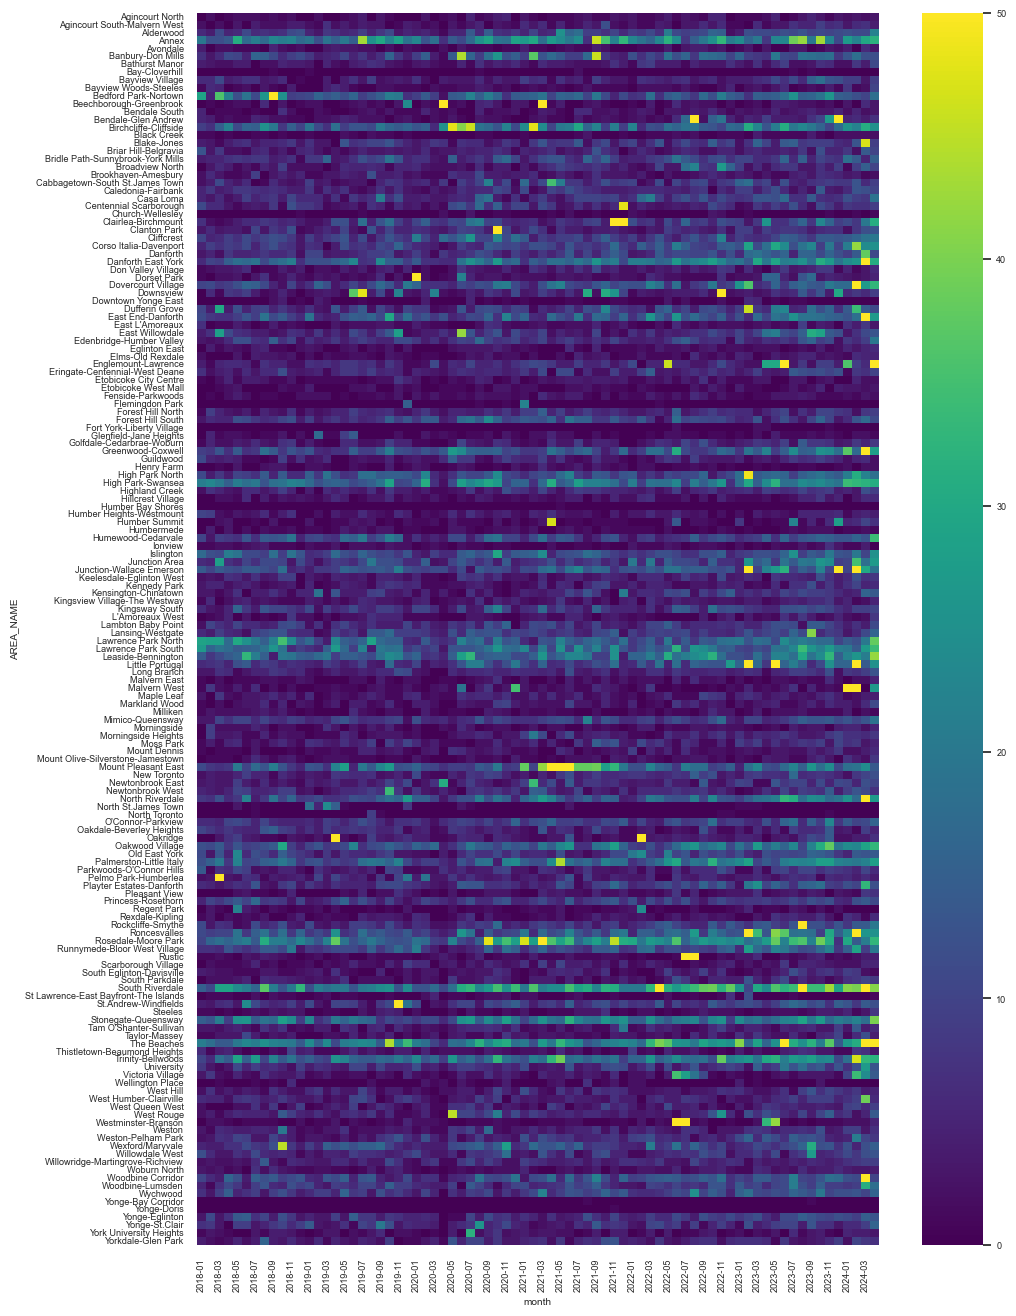

In [174]:
heatmap(plotdata)

#### Clustered (hierarchical) heatmap
Now we will cluster neighbourhoods by permit activity, grouping similar neighbourhoods together. When we do this, we see some distinct clusters of permit activity:
1. Dovercourt, Dufferin Grove, High Park North, and other neighbourhoods in the west end seem to have an concomitant increase in renovation activity: renovations constant until 2023 where permit activity increases noticeably. We see spikes in 2023-02 and 2024-02. Is this something to do with approval processes? Are there city construction projects that could lead to these spikes?
2. The Beaches, The Annex, Rosedale-Moore: areas with constant, relatively high renovation activity
3. Places with little to no residential permit activity correspond to areas with few houses or business districts such as the Yonge-Bay Corridor, Downtown Yonge East, and Church-Wellesley, and to areas with Apartment Buildings and high-density housing that is not captured by residential building permits, such as North St. Jamestown, Regent Park, and Flemingdon Park.



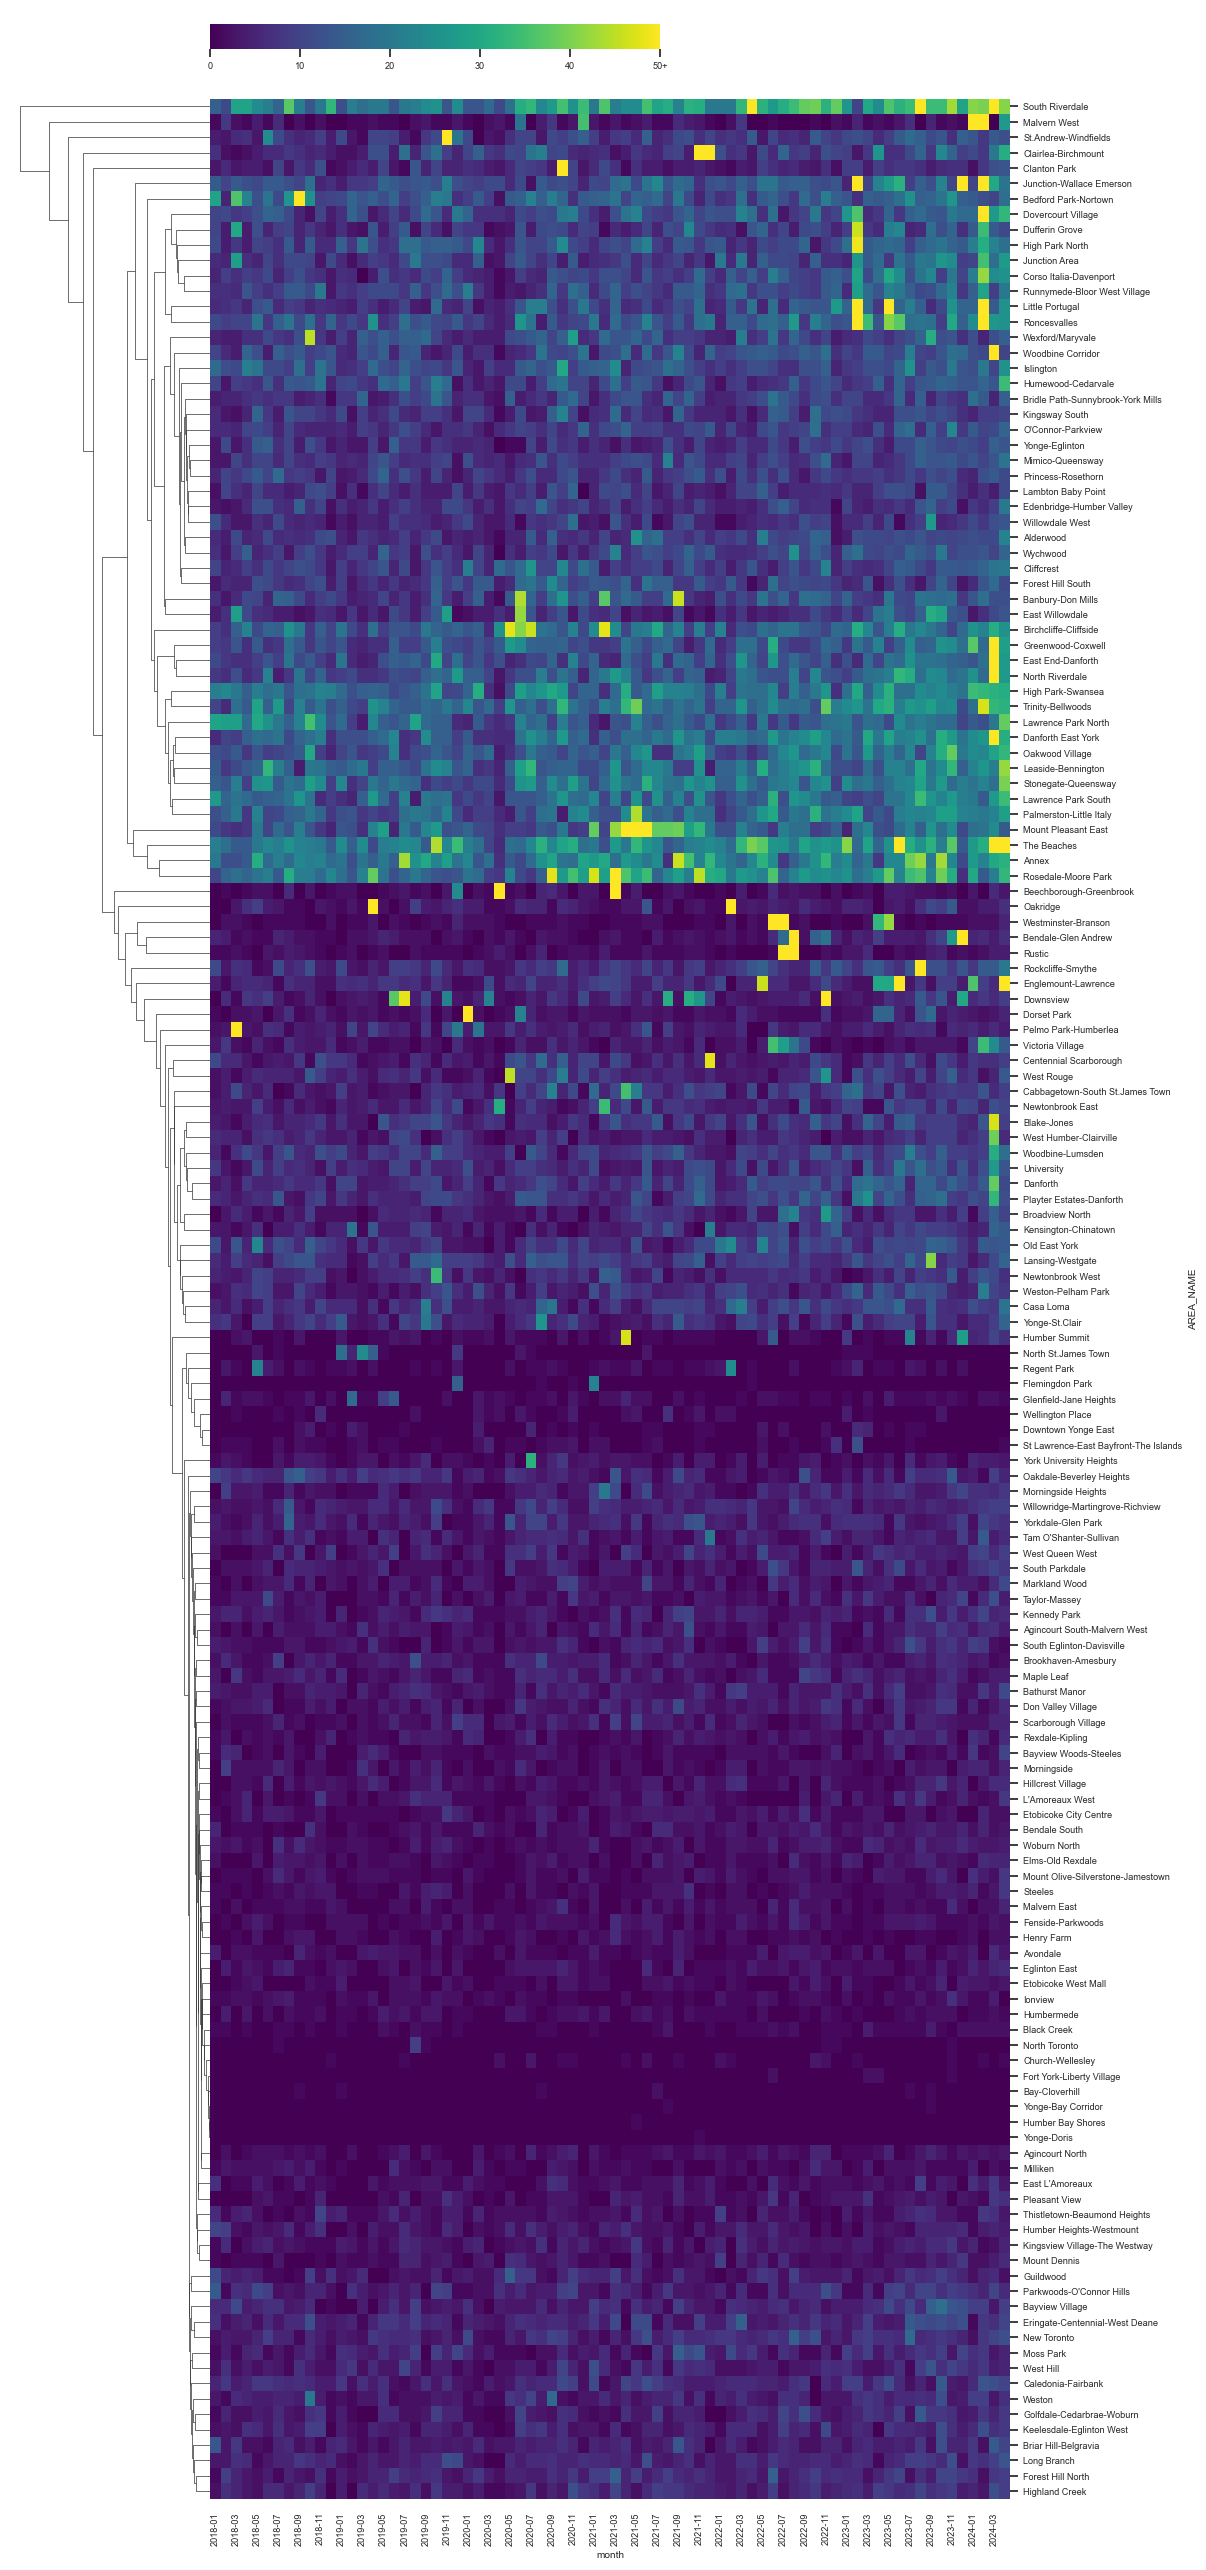

In [175]:
clustermap(plotdata)

### Permit Costs vs. Neighbourhood
#### Naive heatmap
Here we're plotting a naive heatmap of building permit costs by neighbourhood, organized alphabetically. We can immediately see neighbourhoods with much higher permit costs that correlate with known high-income areas: Banbury-Don Mills, Bedford Park-Nortown, Bridle Path-Sunnybrook-York Mills, Lawrence Park North and Lawrence Park South

In [176]:
OLDEST_MONTH = "2018-01"
NEWEST_MONTH = "2024-05"
date_filter = (df_processed["month"] >= OLDEST_MONTH) & (df_processed["month"] < NEWEST_MONTH)
plotdata = df_processed.loc[date_filter].pivot(index="AREA_NAME", columns="month", values="sum_est_costs").fillna(0)

<Axes: xlabel='month', ylabel='AREA_NAME'>

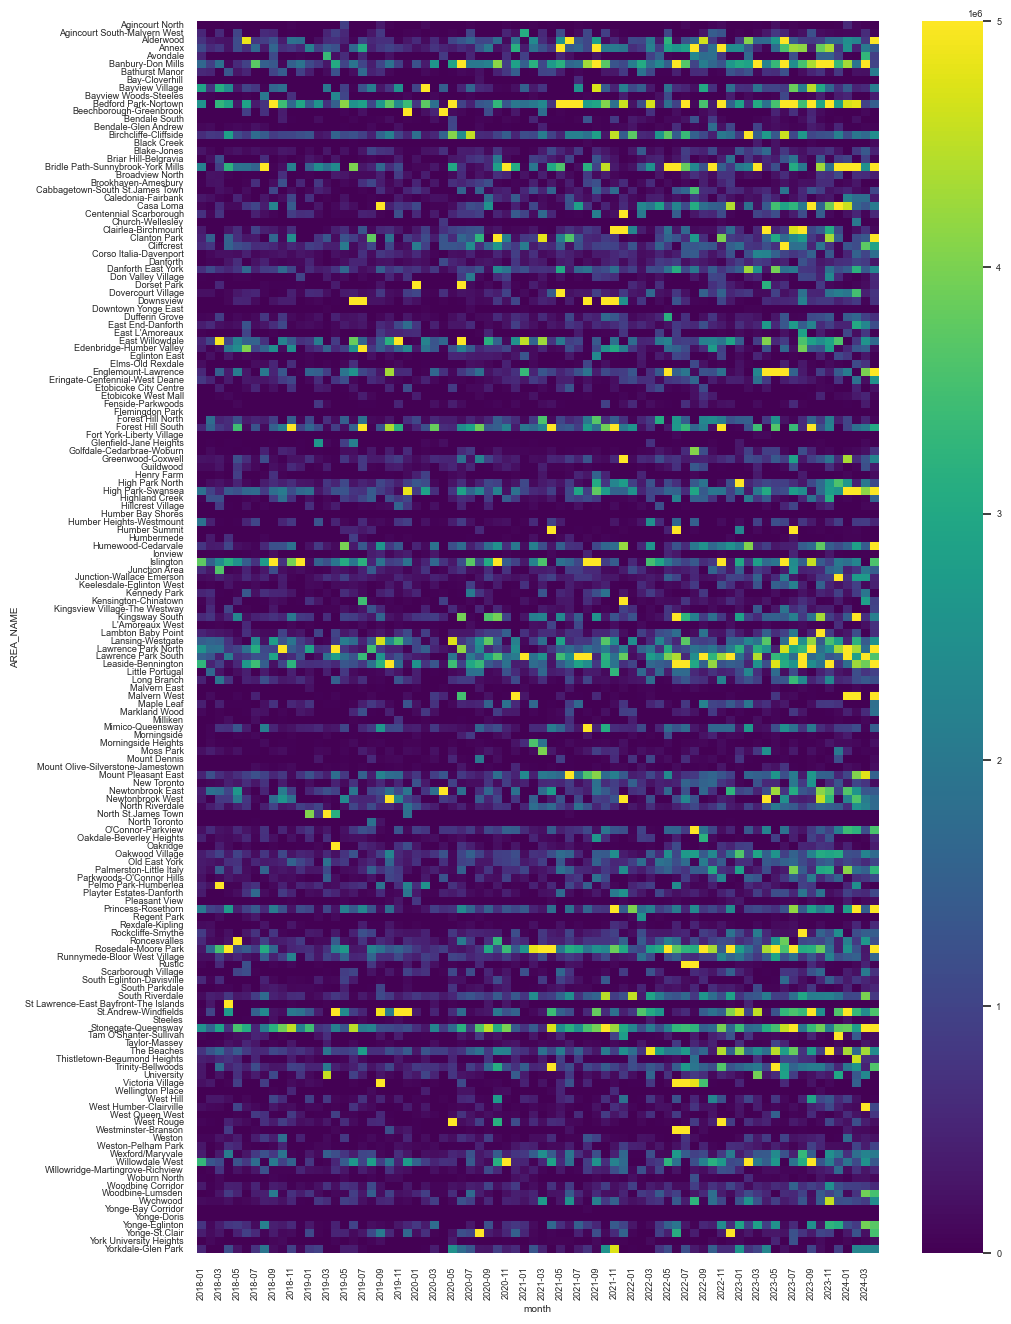

In [177]:
heatmap(plotdata, vmax=5000000)

#### Clustered (hierarchical) heatmap
Clustering neighbourhoods by similarity reinforces what we saw in the naive heatmap: rich neighbourhoods have expensive permits. Neighbourhoods with high permit costs are not necessarily the same as the neighbourhoods with high permit activity. Rather, most of the neighbourhoods with lots of renovation activity have a modest total permit amount. 

We do see some neighbourhoods that are increasing in permit costs, suggesting an increase in affluency, such as The Beaches, Mount Pleasant East, High Park-Swansea, Casa Loma, and The Annex

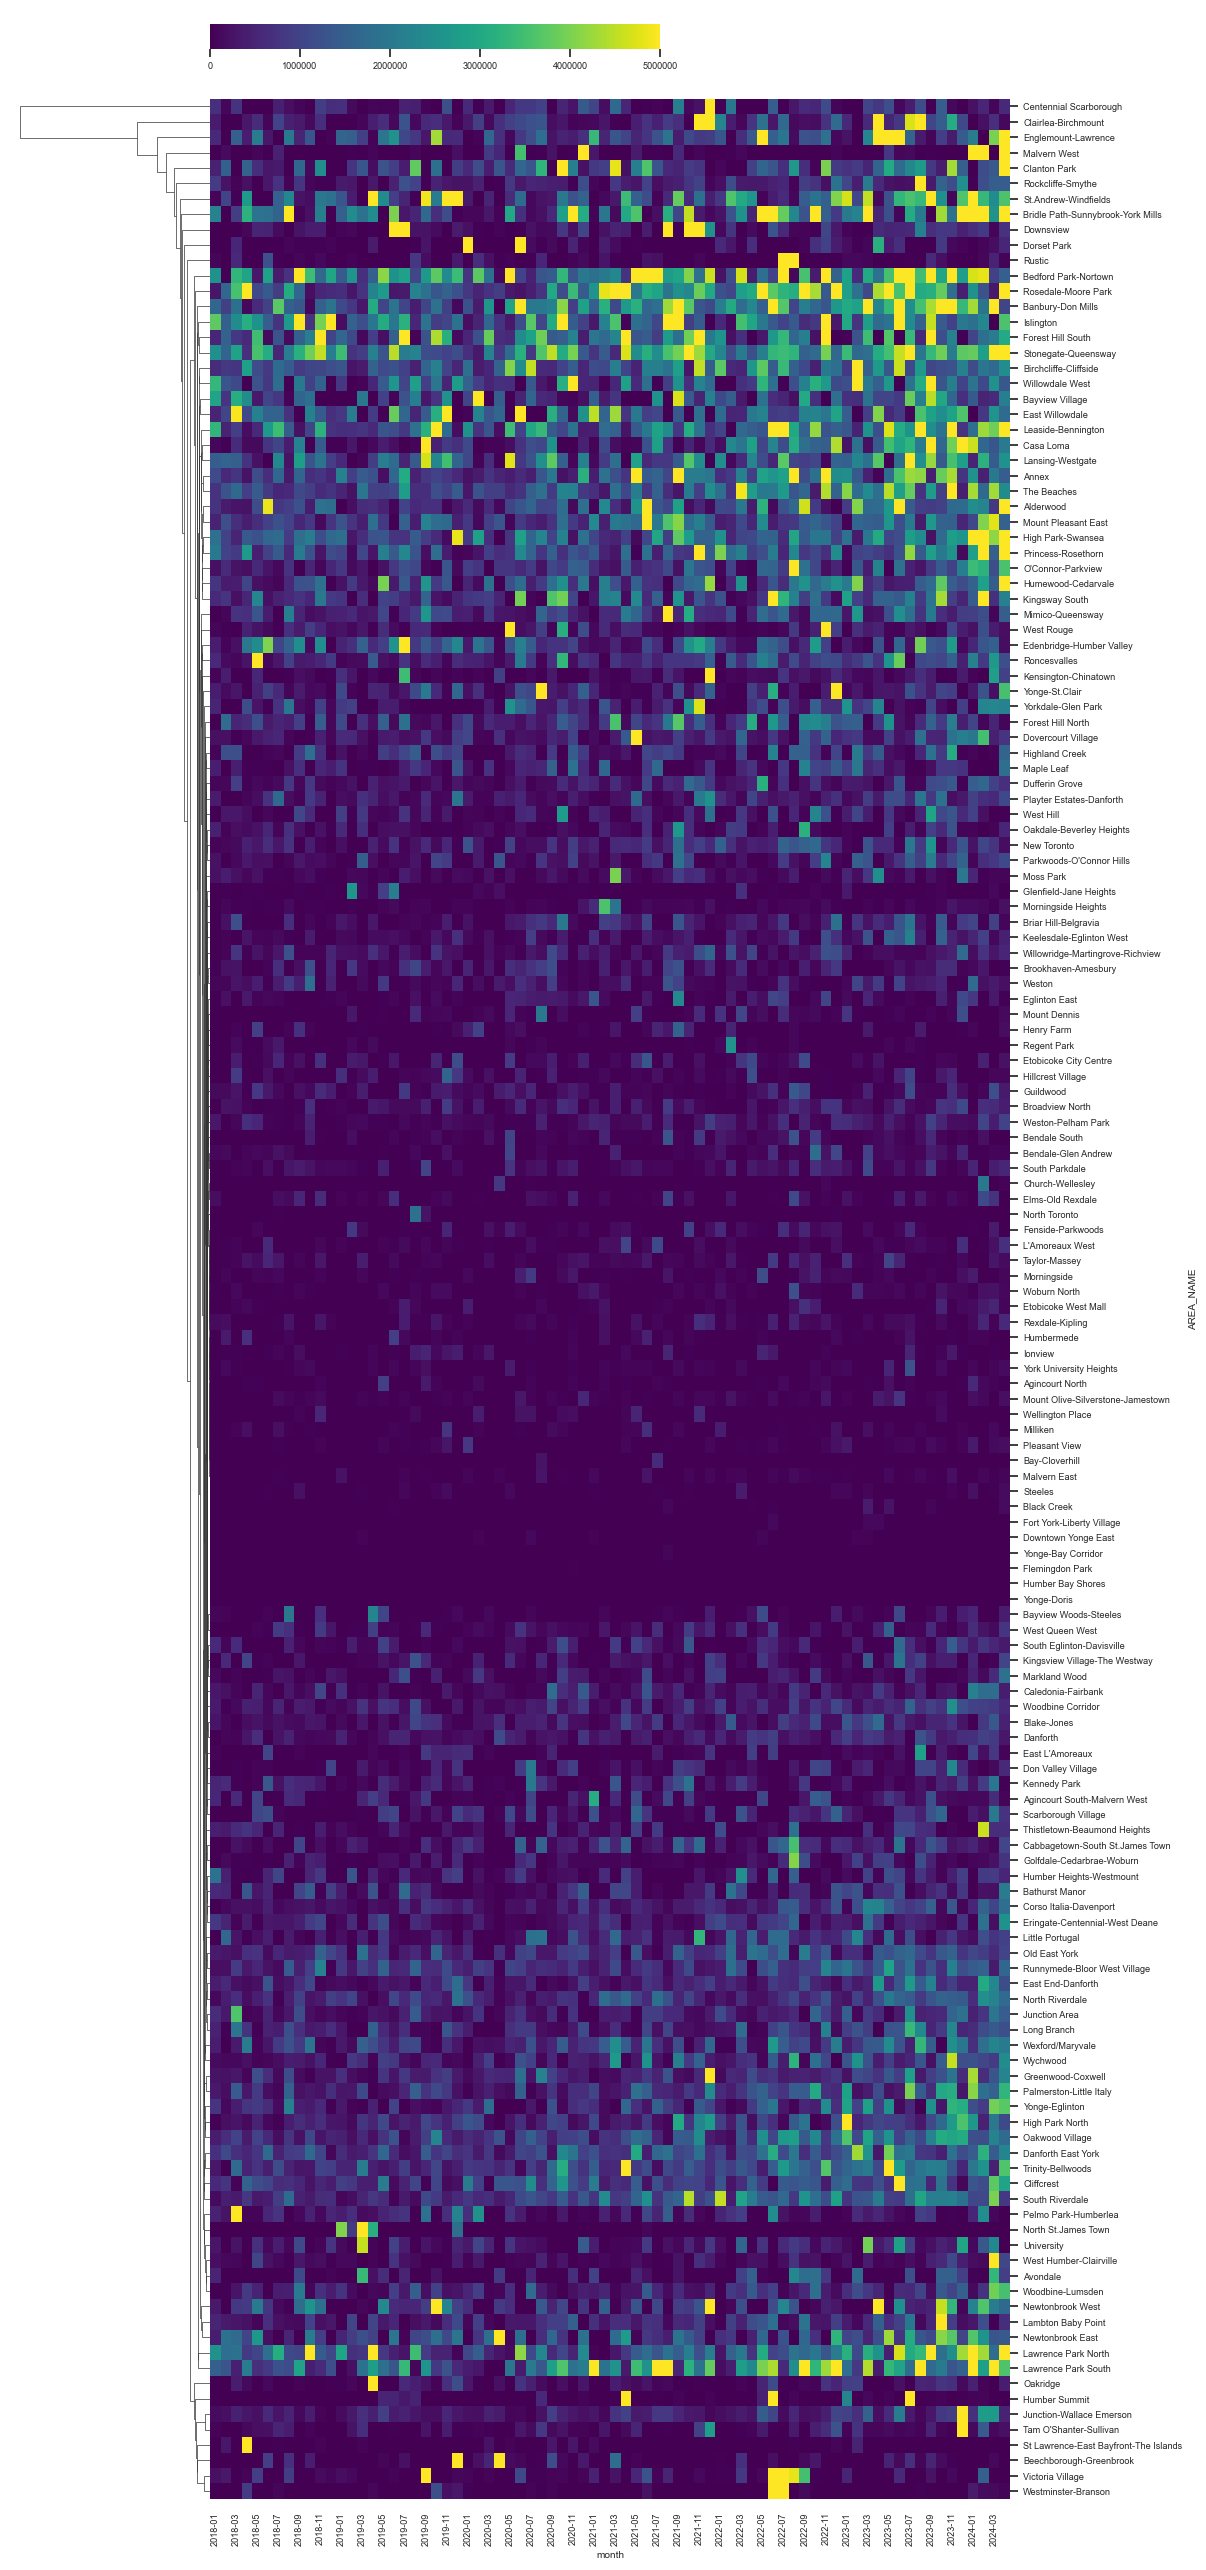

In [178]:
clustermap(plotdata, vmax=5000000)

### Measure activity and permit values on a per household basis
Let's run the same analyses as above but we normalize to number of properties per neighbourhood. **This analysis has some shortcomings, including the following:** 
- This current analysis includes non-residential properties. In the future we need to find a way to filter the municipal address data by use case
- Parcels can be used for both residential and non-residential uses (e.g. a school under an apartment building, less common; an apartment above a store: more common)
- Parcels have been filtered for `ADDRESS_ID`s that have had a permit record associated with them. This should theoretically include only residential addresses, and may exclude residential addresses that have not had a permit associated with it in the publicly available records

In [50]:
df_processed['permits_per_prop'] = df_processed['properties_with_permit']/df_processed['current_property_count']
df_processed['avg_permit_value'] = df_processed['sum_est_costs']/df_processed['num_permits']

In [19]:
OLDEST_MONTH = "2018-01"
NEWEST_MONTH = "2024-05"
date_filter = (df_processed["month"] >= OLDEST_MONTH) & (df_processed["month"] < NEWEST_MONTH)
plotdata = df_processed.loc[date_filter].pivot(index="AREA_NAME", columns="month", values="permits_per_prop").fillna(0)

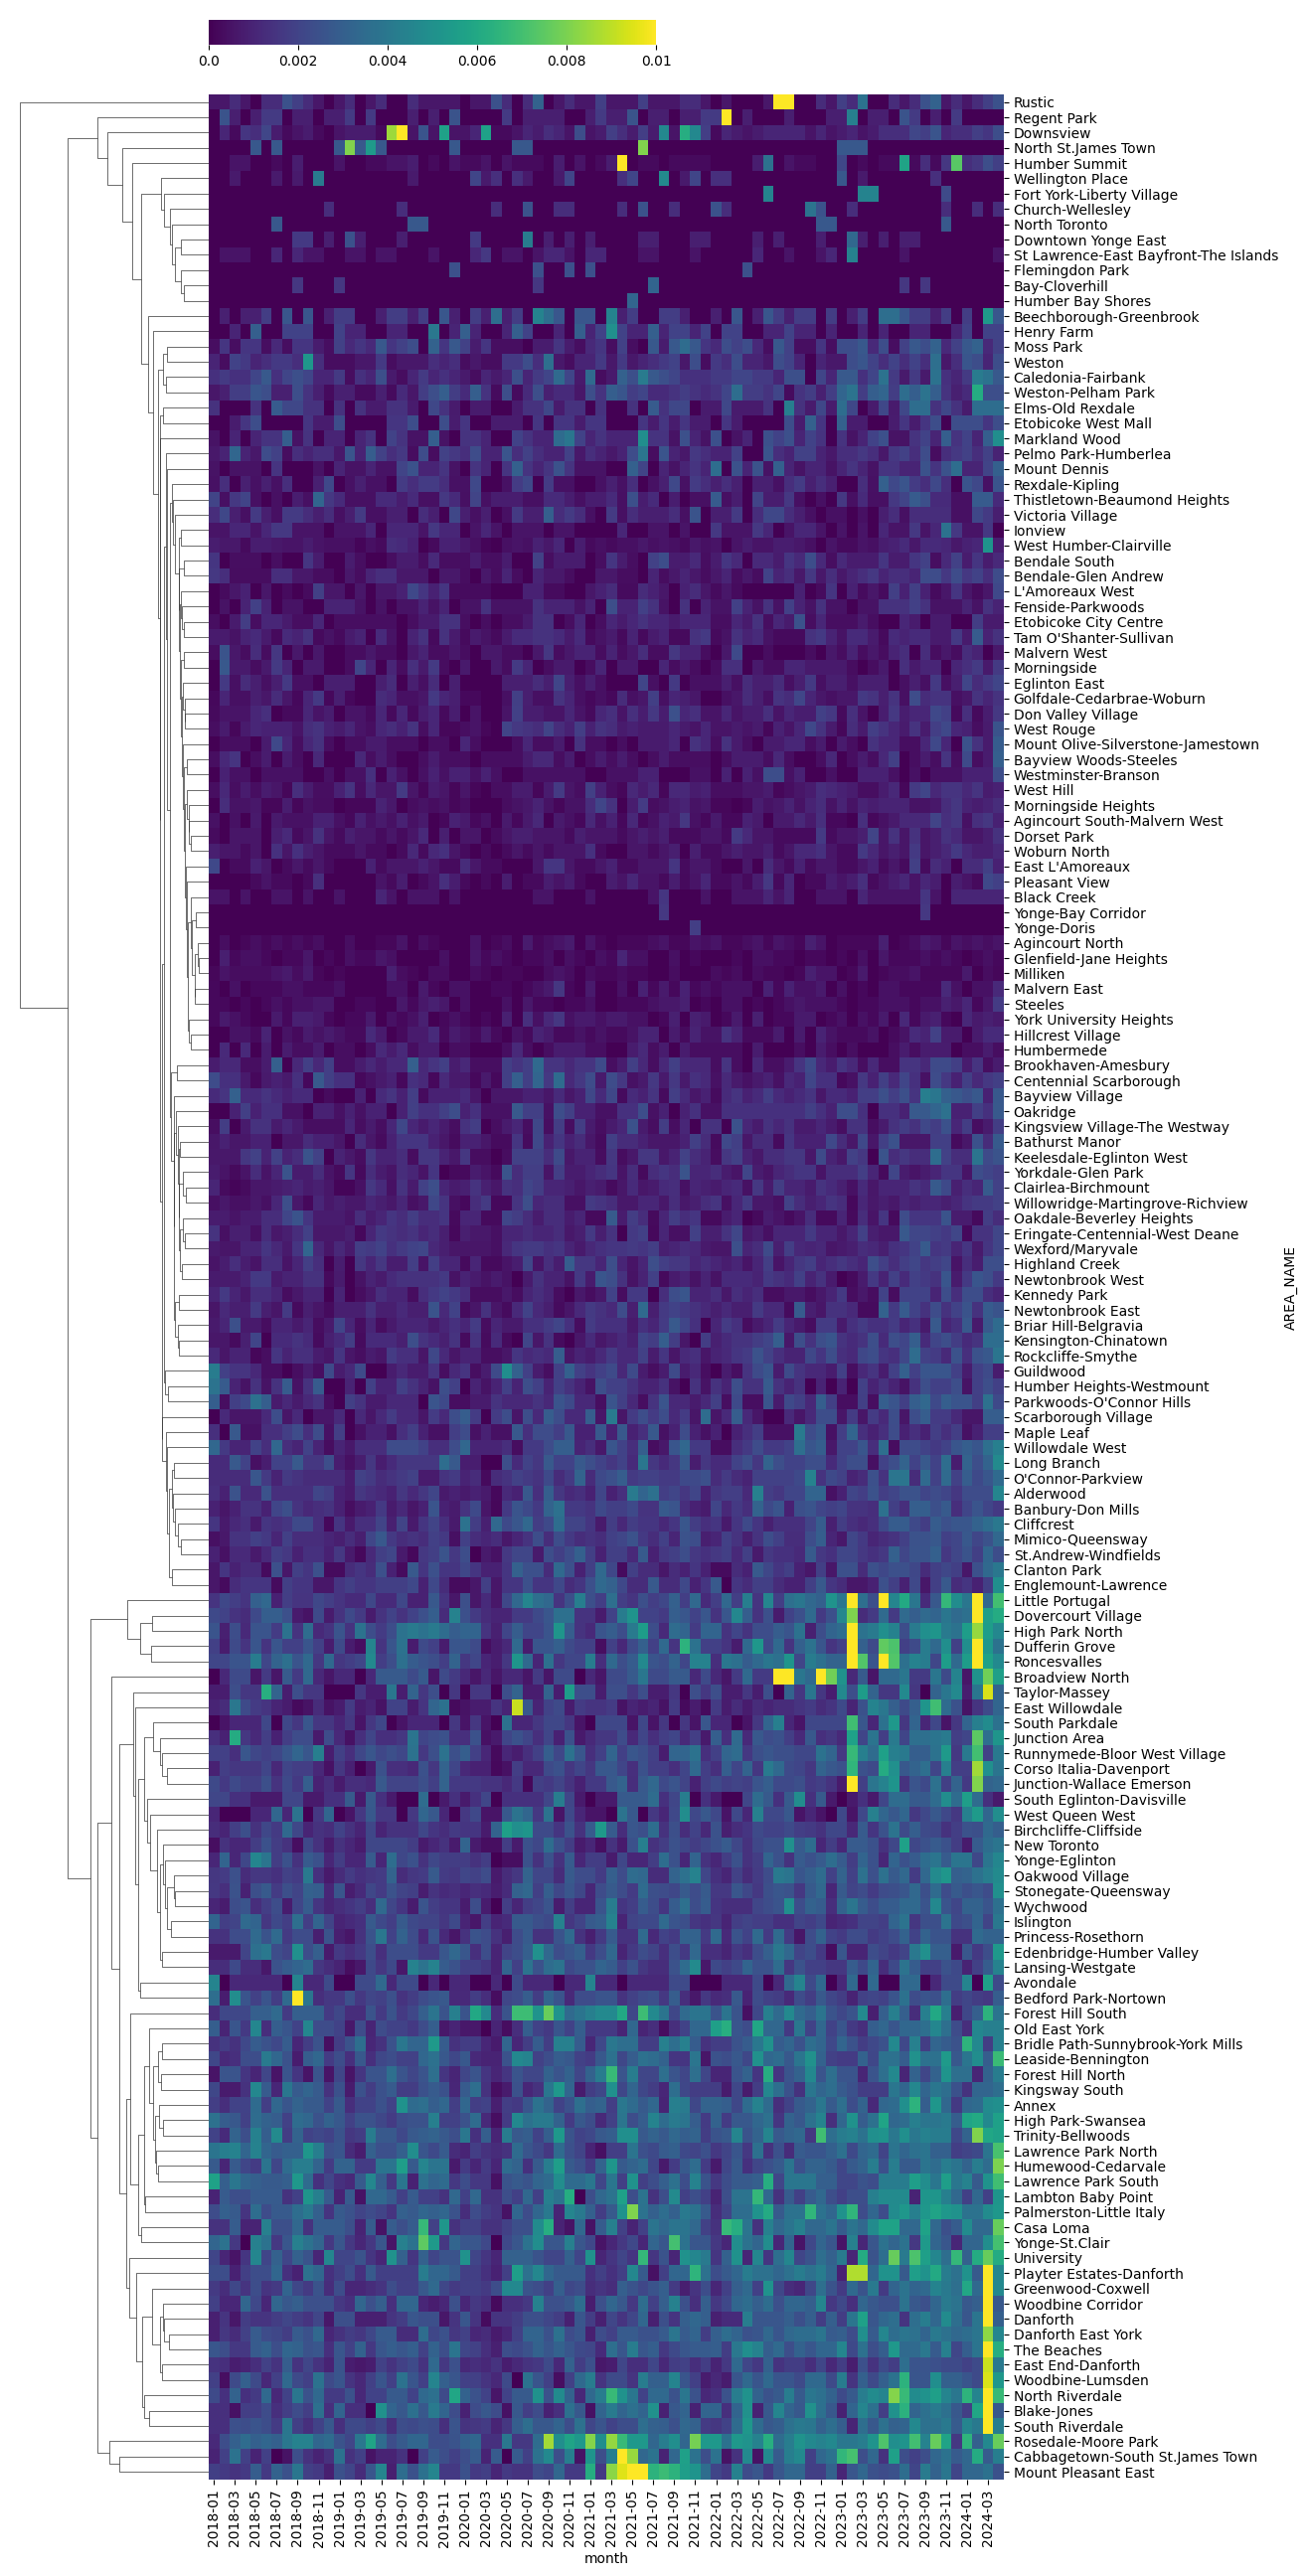

In [35]:
clustermap(plotdata, vmax=0.01)

In [51]:
OLDEST_MONTH = "2018-01"
NEWEST_MONTH = "2024-05"
date_filter = (df_processed["month"] >= OLDEST_MONTH) & (df_processed["month"] < NEWEST_MONTH)
plotdata = df_processed.loc[date_filter].pivot(index="AREA_NAME", columns="month", values="avg_permit_value").fillna(0)

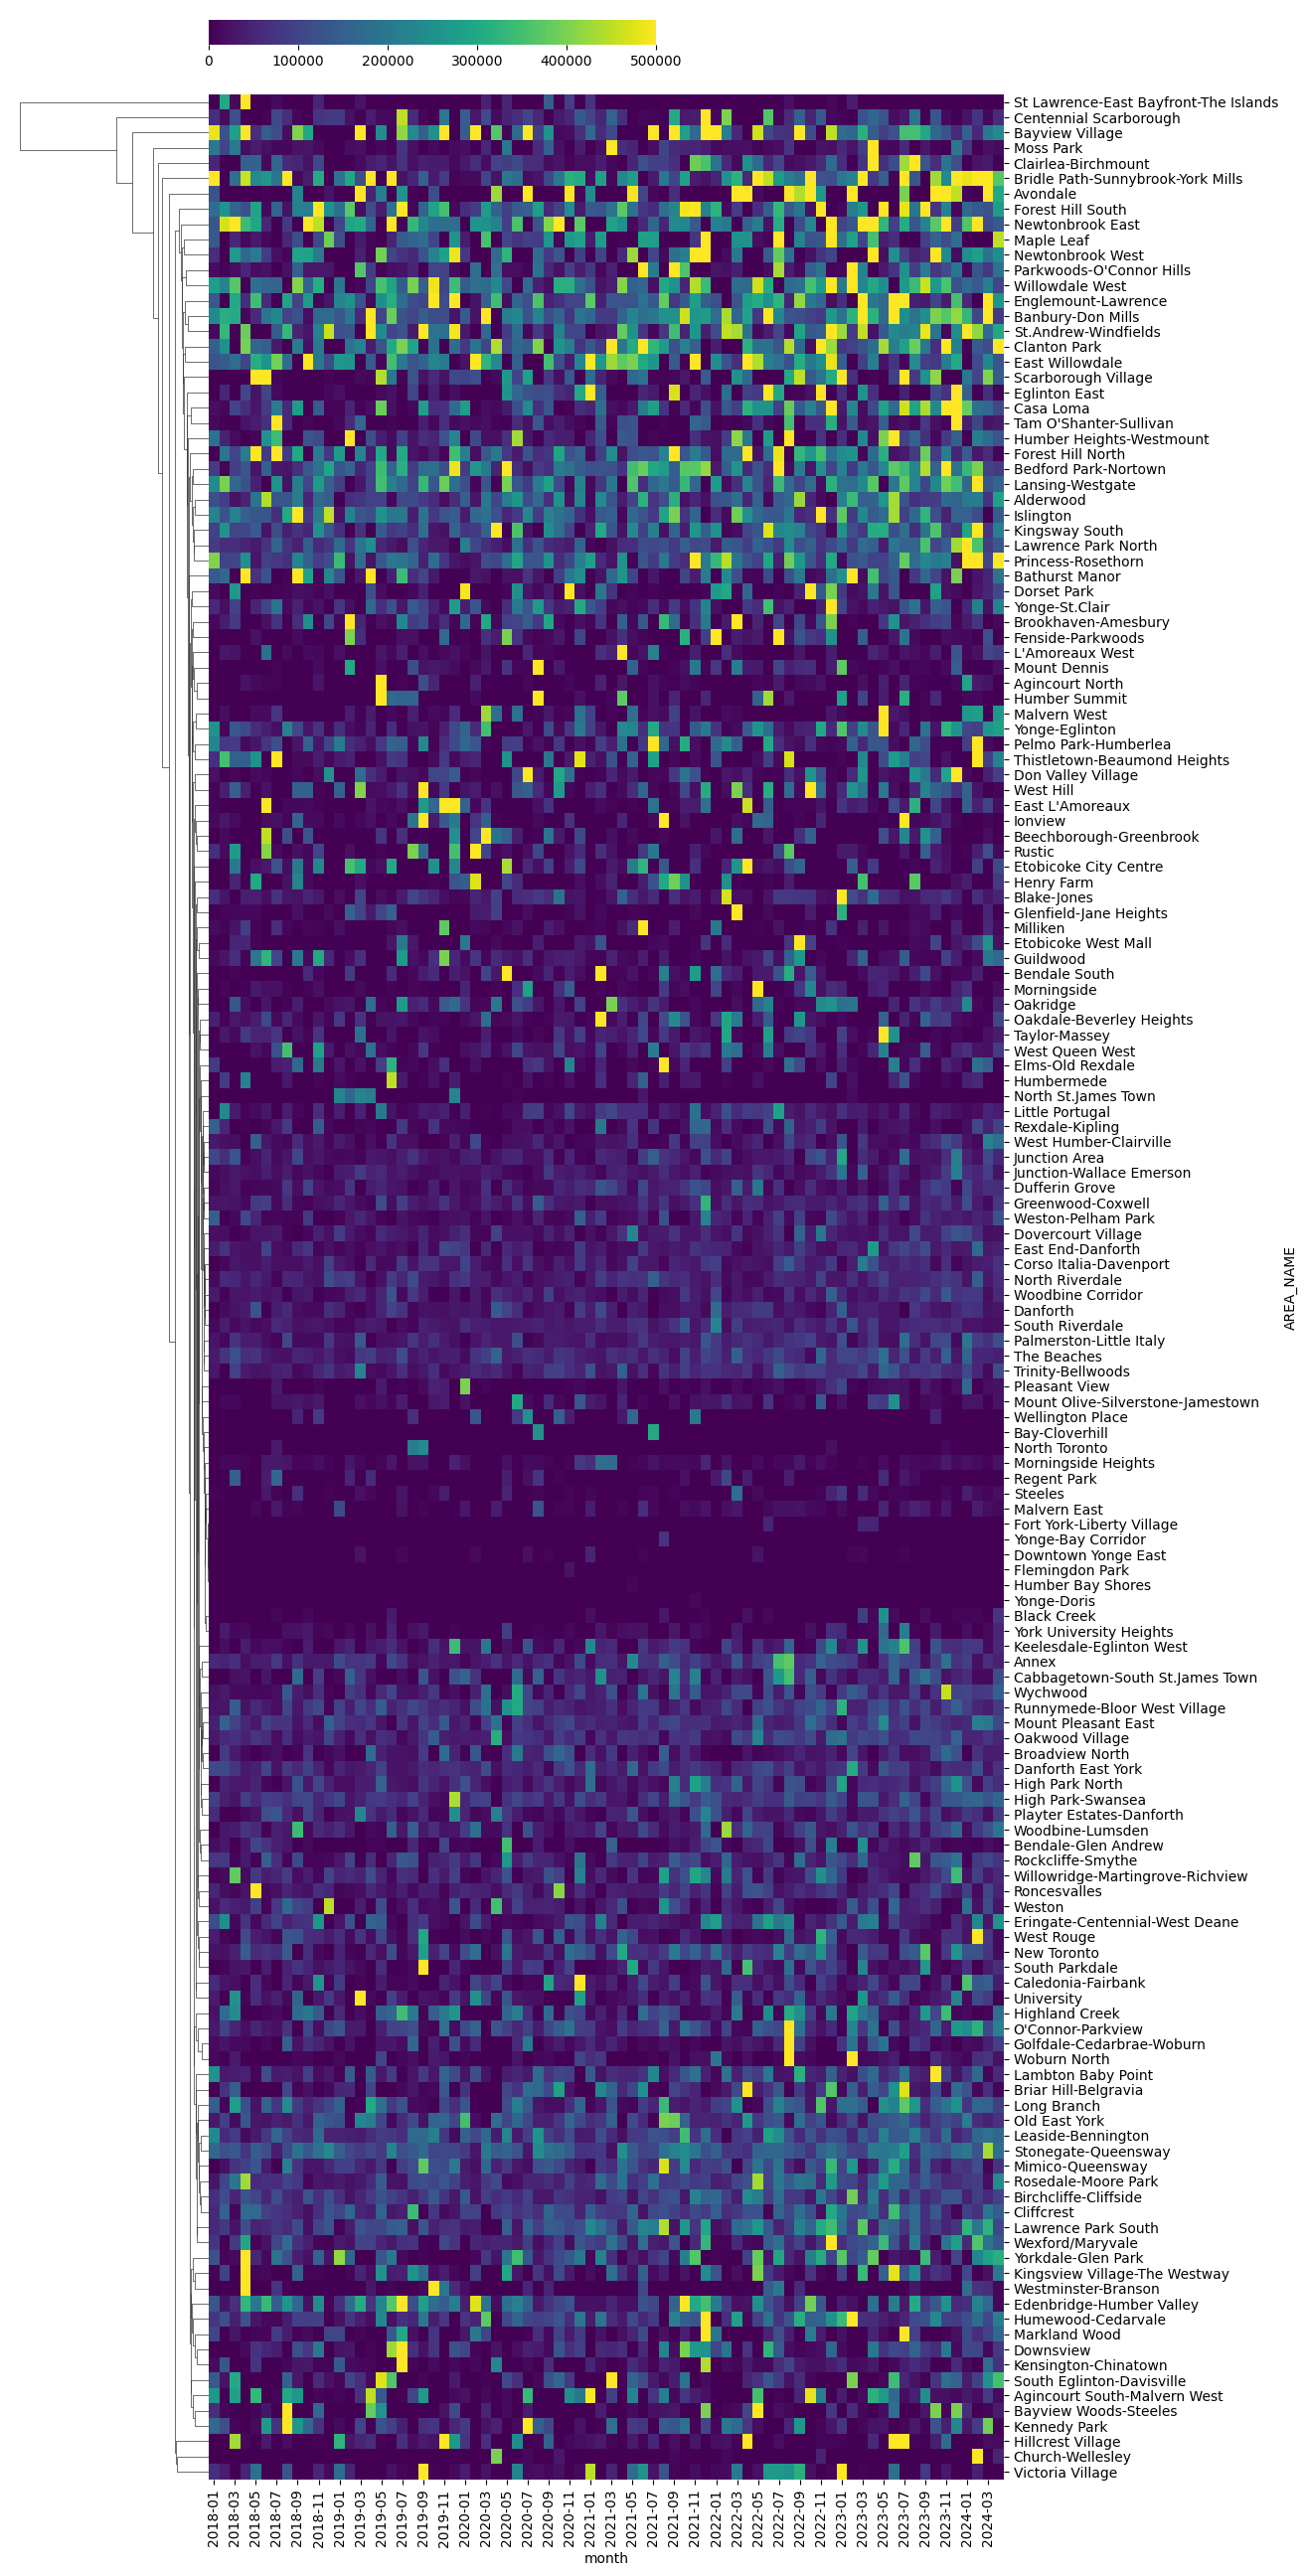

In [52]:
clustermap(plotdata, vmax=500000)